In [1]:
from collections import defaultdict
import json
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import auc
import sys

from Config_NoAnns import get_pairs
    
def interpolate(x, y, x_t):
    y_rev = list(reversed(list(y)))
    x_rev = list(reversed(list(x)))
    return np.interp(x_t, x_rev, y_rev)

def average_same_x(x, y_list):
    n = len(x)
    d = len(y_list)
    out = []
    for i in range(n):
        v = 0.0
        for j in range(d):
            v += y_list[j][i]
        v /= d
        out.append(v)
    return out

In [2]:
modes = {'initial-tune': 'Baseline', 'spire': 'SPIRE', 'fs-3': 'FS', 'na-transfer': 'NoAnns'}
trials = [0,1,2,3,4,5,6,7]
baseline = 'initial-tune'
corrected_list = ['spire', 'fs-3', 'na-transfer']

pairs = get_pairs()

# Analysis of Individual SPs (average across trials per SP)

tennis+racket-person

Baseline
AP Orig: 0.9387659934896494
Average Recall Gap: 0.2638991737291822
Average Hallucination Gap: 0.00813383967724399
Recall at 0.5 threshold: 0.6450086058519794
Metrics at chosen level of recall:
both 0.8548
just_main 0.4452
just_spurious 0.9946
neither 0.9999
r-gap 0.4096
h-gap 0.0053
precision 0.8954


SPIRE
AP Orig: 0.9291770221718567
Average Recall Gap: 0.18135894386022805
Average Hallucination Gap: 0.005915057204106323
Recall at 0.5 threshold: 0.6171256454388985
Metrics at chosen level of recall:
both 0.8186
just_main 0.4814
just_spurious 0.9954
neither 0.9994
r-gap 0.3372
h-gap 0.0041
precision 0.8979


FS
AP Orig: 0.9294777284539004
Average Recall Gap: 0.2364279784333015
Average Hallucination Gap: 0.006318532121165292
Recall at 0.5 threshold: 0.6299483648881239
Metrics at chosen level of recall:
both 0.8379
just_main 0.4621
just_spurious 0.9957
neither 0.9999
r-gap 0.3759
h-gap 0.0043
precision 0.9133


NoAnns
AP Orig: 0.9403261556843414
Average Recal

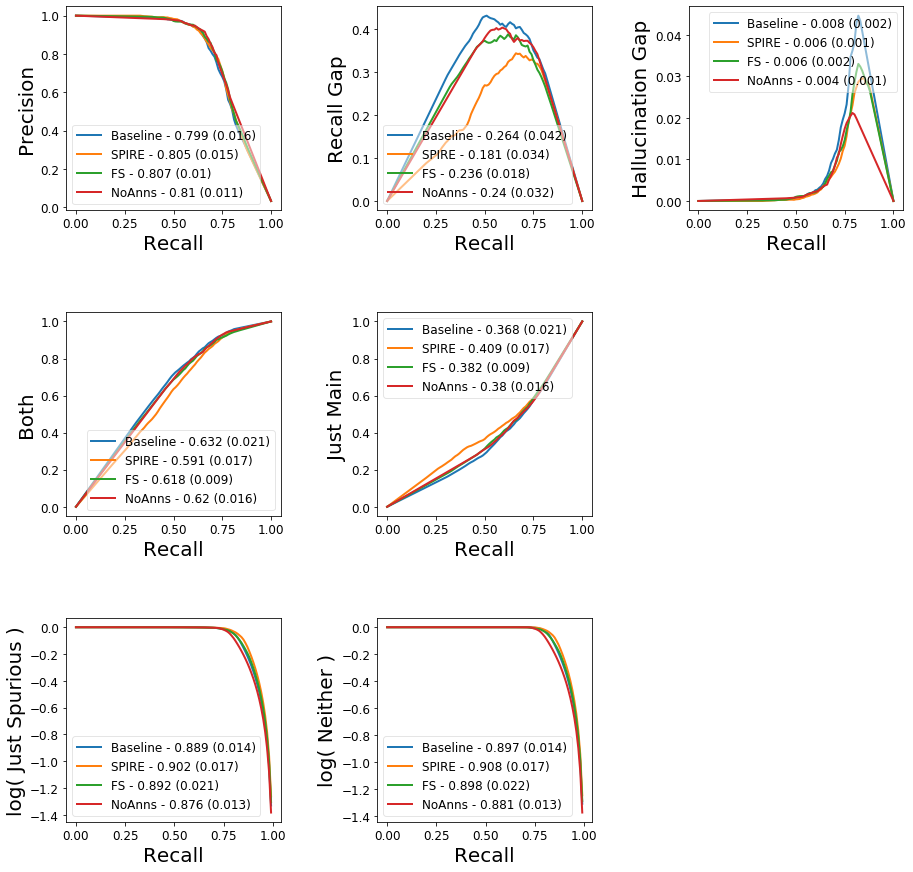

In [3]:

inspect_pair = True
if inspect_pair:
    index_target = 65 # Threshold of 0.5 for the original model gives recall of 65%
    pair_target = 'tennis+racket-person'
    pair_main = 'tennis racket'

show_accs = True
np.seterr(divide = 'ignore') 

mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

ts = np.linspace(0, 1, num = 101)

data = {}
for mode in modes:
    data[mode] = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 

pr = {}
for mode in modes:
    pr[mode] = []
    
for pair in pairs:
    print(pair)

    if show_accs:
        fig, ax_all = plt.subplots(3, 3)
        fig.set_figheight(15)
        fig.set_figwidth(15)        
    else:
        fig, ax_all = plt.subplots(1, 3)
        fig.set_figheight(5)
        fig.set_figwidth(15)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.45)
    
    for mode in modes:

        ap_orig = []
        values = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 
        curves = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 
        for trial in trials:

            with open('./2-Models/Models/{}/trial{}/results.pkl'.format(mode, trial), 'rb') as f:
                results = pickle.load(f)

            ap_orig.append(results['AP-orig'][pair_main])
            
            results = results[pair]
                
            curve_tmp = interpolate(results['recall'], results['precision'], ts)
            curves['ap'].append(curve_tmp)
            values['ap'].append(auc(ts, curve_tmp))
                    
            for name in curves:
                if name != 'ap':
                    curve_tmp = interpolate(results['recall'], results[name], ts)
                    curves[name].append(curve_tmp)
                    values[name].append(auc(ts, curve_tmp))

        values_avg = {}
        values_std = {}
        curves_avg = {}
        for name in values:
            values_avg[name] = np.round(np.mean(values[name]), 3)
            data[mode][name].append(np.mean(values[name]))
            values_std[name] = np.round(np.std(values[name]), 3)
            curves_avg[name] = average_same_x(ts, curves[name])
            
        if inspect_pair and pair == pair_target:
            print()
            print(modes[mode])
            print('AP Orig:', np.mean(ap_orig))
            print('Average Recall Gap:', np.mean(values['r-gap']))
            print('Average Hallucination Gap:', np.mean(values['h-gap']))
            print('Recall at 0.5 threshold:', 0.5 * (results['both'][51] + results['just_main'][51]))
            print('Metrics at chosen level of recall:')
            for name in ['both', 'just_main', 'just_spurious', 'neither', 'r-gap', 'h-gap', 'ap']:
                if name != 'ap':
                    print(name, np.round(curves_avg[name][index_target], 4))
                else:
                    print('precision', np.round(curves_avg['ap'][index_target], 4))
            print()
        
        pr[mode].append(curves_avg['ap'])
        
        if show_accs:
            ax = ax_all[0,0]
        else:
            ax = ax_all[0]
        ax.plot(ts, curves_avg['ap'], label = '{} - {} ({})'.format(modes[mode], values_avg['ap'], values_std['ap']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        
        if show_accs:
            ax = ax_all[0,1]
        else:
            ax = ax_all[1]
        ax.plot(ts, curves_avg['r-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['r-gap'], values_std['r-gap']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Recall Gap')
        ax.legend()
        
        if show_accs:
            ax = ax_all[0,2]
        else:
            ax = ax_all[2]
        ax.plot(ts, curves_avg['h-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['h-gap'], values_std['h-gap']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Hallucination Gap')
        ax.legend()
        
        if show_accs:
            ax = ax_all[1,0]
            ax.plot(ts, curves_avg['both'], label = '{} - {} ({})'.format(modes[mode], values_avg['both'], values_std['both']))
            ax.set_xlabel('Recall')
            ax.set_ylabel('Both')
            ax.legend()

            ax = ax_all[1,1]
            ax.plot(ts, curves_avg['just_main'], label = '{} - {} ({})'.format(modes[mode], values_avg['just_main'], values_std['just_main']))
            ax.set_xlabel('Recall')
            ax.set_ylabel('Just Main')
            ax.legend()

            ax = ax_all[2,0]
            ax.plot(ts, np.log10(curves_avg['just_spurious']), label = '{} - {} ({})'.format(modes[mode], values_avg['just_spurious'], values_std['just_spurious']))
            ax.set_xlabel('Recall')
            ax.set_ylabel('log( Just Spurious )')
            #ax.set_ylim(bottom = -0.01, top = 0.02)
            ax.legend()

            ax = ax_all[2,1]
            ax.plot(ts, np.log10(curves_avg['neither']), label = '{} - {} ({})'.format(modes[mode], values_avg['neither'], values_std['neither']))
            ax.set_xlabel('Recall')
            ax.set_ylabel('log( Neither )')
            #ax.set_ylim(bottom = -0.01, top = 0.02)
            ax.legend()
            
            ax_all[1,2].set_axis_off()
            ax_all[2,2].set_axis_off()
        
    plt.show()
    plt.close()

np.seterr(divide = 'warn');
